### Import python files from another directory
In order to reuse code written in .py files you need to import them. <br/>
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [1]:
import sys
sys.path.append("../../ex02/template") # This goes up twice in the directories tree (hence in labs)
                                       # then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [2]:
from grid_search import *

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [4]:
from helpers import *

def compute_error(y, tx, w):
    # print(tx.shape, w.shape)
    return y - tx @ w

def compute_loss(y, tx, w):
    """Calculate the loss with MSE.
    """
    e = compute_error(y, tx, w)

    return np.sum((e ** 2), axis=0) / (2 * len(y)) 
def compute_rmse(y, tx, w):
    """Calculate the loss with RMSE.
    """
    mse = compute_loss(y, tx, w)
    return np.sqrt(2 * mse)

def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.lstsq(tx, y, rcond=None)[0] # if X is not full rank, w minimize MAE
    mse = compute_loss(y, tx, w)
    return mse, w


In [5]:
test_y = np.array([1,2])
test_x = np.arange(4).reshape(2,2)
test_x = np.c_[np.ones(test_x.shape[0]), test_x]
test_w = np.ones(3)
test_x, test_y, test_w

(array([[1., 0., 1.],
        [1., 2., 3.]]),
 array([1, 2]),
 array([1., 1., 1.]))

In [6]:
print(compute_error(test_y, test_x, test_w))
print(compute_loss(test_y, test_x, test_w))
print(least_squares(test_y, test_x))

[-1. -4.]
4.25
(2.465190328815662e-31, array([5.00000000e-01, 4.55224306e-16, 5.00000000e-01]))


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [7]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search: TODO
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    # ***************************************************
    ls_loss, ls_w = least_squares(y, tx)
    gs_loss, gs_w = grid_search(y, tx, num_intervals=100)
    print('Least squares loss: {:.2f}, optimal weight: {}'.format(ls_loss, ls_w))
    print('Grid search loss:{:.2f}, optimal weight: {}'.format(gs_loss, gs_w))

Test it here

In [8]:
test_your_least_squares()

Least squares loss: 15.39, optimal weight: [73.293922   13.47971243]
Grid search loss:15.56, optimal weight: [72.72727272727272, 13.636363636363626]


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [9]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [10]:
from helpers import *
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    if degree <= 0:
        raise ValueError("degree should be >= 1")
    x, _, _ = standardize(x)
    px = np.vstack([x**j for j in range(0,degree+1)])
    return px.T

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [12]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        px = build_poly(x, degree)
        mse, weights = least_squares(y, px)
        rmse = np.sqrt(2 * mse)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773748
Processing 3th experiment, degree=7, rmse=0.24965870360907508
Processing 4th experiment, degree=12, rmse=0.24032507466876504


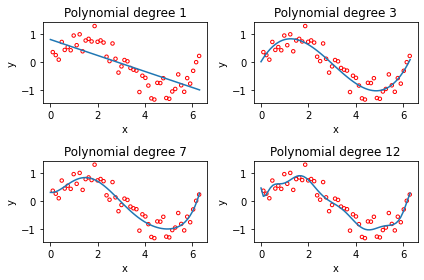

In [14]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [15]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # split the data based on the given ratio:
    n = len(y)
    n_train =  int(ratio * n)
    if not (n_train > 0 and n > n_train):
        raise ValueError('split ratio incorret')
    index = np.arange(n)
    np.random.shuffle(index)
    train_idx = index[:n_train]
    test_idx = index[n_train:]
    return (x[train_idx], y[train_idx]), (x[test_idx], y[test_idx])

In [16]:
tr, te = split_data(x, y, ratio=0.5, seed=1)
te[0].shape

(25,)

Then, test your `split_data` function below.

In [17]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # split the data, and return train and test data
    train_xy, test_xy = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function
    train_x = build_poly(train_xy[0], degree)
    test_x = build_poly(test_xy[0], degree)
    train_y = train_xy[1]
    test_y = test_xy[1]

    # calculate weight through least square
    train_mse, w = least_squares(train_y, train_x)
    test_mse = compute_loss(test_y, test_x, w)

    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: 
    rmse_tr = np.sqrt(2 * train_mse)
    rmse_te = np.sqrt(2 * test_mse)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [18]:
seed = 1
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.455, Testing RMSE=0.561
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.467
proportion=0.9, degree=7, Training RMSE=0.257, Testing RMSE=0.485
proportion=0.9, degree=12, Training RMSE=0.246, Testing RMSE=0.486
proportion=0.5, degree=1, Training RMSE=0.400, Testing RMSE=0.576
proportion=0.5, degree=3, Training RMSE=0.237, Testing RMSE=0.395
proportion=0.5, degree=7, Training RMSE=0.218, Testing RMSE=0.446
proportion=0.5, degree=12, Training RMSE=0.187, Testing RMSE=0.713
proportion=0.1, degree=1, Training RMSE=0.453, Testing RMSE=0.539
proportion=0.1, degree=3, Training RMSE=0.111, Testing RMSE=0.649
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=3.011
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=24.582


# 3 Ridge Regression
Please fill in the function below.

In [19]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    lambda_I = lambda_* (2 * tx.shape[0]) * np.identity(tx.shape[1])
    A = tx.T @ tx + lambda_I
    # w = np.linalg.lstsq(A, tx.T.dot(y), rcond=None)[0]
    w = np.linalg.solve(A, tx.T.dot(y))
    return w

In [29]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # lambdas = np.linspace(0, 1, 15)

 
    # split the data, and return train and test data: 
    xy_tr, xy_te = split_data(x, y, ratio, seed)
 
    # form train and test data with polynomial basis function:
    x_tr = build_poly(xy_tr[0], degree)
    x_te = build_poly(xy_te[0], degree)
    y_tr = xy_tr[1]
    y_te = xy_te[1]

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression with a given lambda
        w = ridge_regression(y_tr, x_tr, lambda_)
        rmse_tr.append(compute_rmse(y_tr, x_tr, w))
        rmse_te.append(compute_rmse(y_te, x_te, w))

        print("proportion={p}, degree={d}, lambda={l:.3e}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.9, degree=7, lambda=1.000e-05, Training RMSE=0.257, Testing RMSE=0.484
proportion=0.9, degree=7, lambda=2.276e-05, Training RMSE=0.257, Testing RMSE=0.484
proportion=0.9, degree=7, lambda=5.179e-05, Training RMSE=0.257, Testing RMSE=0.483
proportion=0.9, degree=7, lambda=1.179e-04, Training RMSE=0.257, Testing RMSE=0.482
proportion=0.9, degree=7, lambda=2.683e-04, Training RMSE=0.257, Testing RMSE=0.479
proportion=0.9, degree=7, lambda=6.105e-04, Training RMSE=0.258, Testing RMSE=0.475
proportion=0.9, degree=7, lambda=1.389e-03, Training RMSE=0.259, Testing RMSE=0.470
proportion=0.9, degree=7, lambda=3.162e-03, Training RMSE=0.262, Testing RMSE=0.466
proportion=0.9, degree=7, lambda=7.197e-03, Training RMSE=0.268, Testing RMSE=0.466
proportion=0.9, degree=7, lambda=1.638e-02, Training RMSE=0.283, Testing RMSE=0.475
proportion=0.9, degree=7, lambda=3.728e-02, Training RMSE=0.315, Testing RMSE=0.496
proportion=0.9, degree=7, lambda=8.483e-02, Training RMSE=0.363, Testing RMS

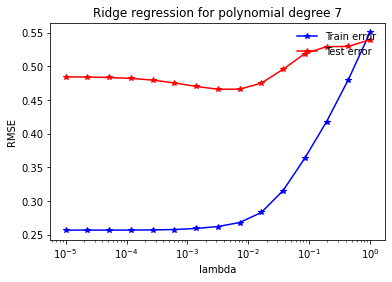

In [30]:
seed = 1
degree = 7
split_ratio = 0.9
ridge_regression_demo(x, y, degree, split_ratio, seed)